## Ian Weimer

## Time Series Traffic Volume Prediction

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from keras.models import Model
from keras.layers import Input, GRU
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import LearningRateScheduler
from keras.layers.normalization import BatchNormalization
from keras import regularizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('drive')

Mounted at drive


## Loading the Data

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz',
    fname='Metro_Interstate_Traffic_Volume.csv.gz',
    cache_dir='/content', cache_subdir='sample_data')
# colab doesn't know how to automatically gunzip a file 
!gunzip sample_data/Metro_Interstate_Traffic_Volume.csv.gz
csv_path, _ = os.path.splitext(zip_path)  # just strip off the .gz
csv_path                                  # should be '/content/sample_data/Metro_Interstate_Traffic_Volume.csv'

409600/405373 [==============================] - 0s 0us/step


'/content/sample_data/Metro_Interstate_Traffic_Volume.csv'

In [ ]:
df = pd.read_csv(csv_path)

## Preprocessing and Exploratory Data Analysis 

In [ ]:
#date_time = pd.to_datetime(df.pop('date_time'), format='%Y-%m-%d %H:%M:%S')

In [ ]:
df.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
5,None,291.72,0.0,0.0,1,Clear,sky is clear,2012-10-02 14:00:00,5181
6,None,293.17,0.0,0.0,1,Clear,sky is clear,2012-10-02 15:00:00,5584
7,None,293.86,0.0,0.0,1,Clear,sky is clear,2012-10-02 16:00:00,6015
8,None,294.14,0.0,0.0,20,Clouds,few clouds,2012-10-02 17:00:00,5791
9,None,293.10,0.0,0.0,20,Clouds,few clouds,2012-10-02 18:00:00,4770


In [ ]:
df_c = df.copy()

In [ ]:
df_c.shape

(48204, 9)

In [ ]:
df_c.nunique()

holiday                   12
temp                    5843
rain_1h                  372
snow_1h                   12
clouds_all                60
weather_main              11
weather_description       38
date_time              40575
traffic_volume          6704
dtype: int64

In [ ]:
df_c.isnull().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

No missing values. Although, as was pointed out on the Discord, and is revealed above in the nunique() check of the dataset regarding date_time, there are repeated values for date_time, 7629 of them. And there is a range of dates missing from 2014 to 2015, of around a year. These dates appear to have been removed from the dataset. 

### Visualizing Traffic Volume

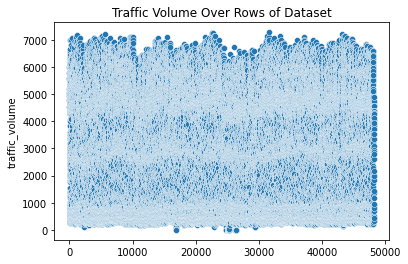

In [ ]:
ax = sns.scatterplot(data=df_c['traffic_volume'])
ax.set_title('Traffic Volume Over Rows of Dataset')
plt.show()

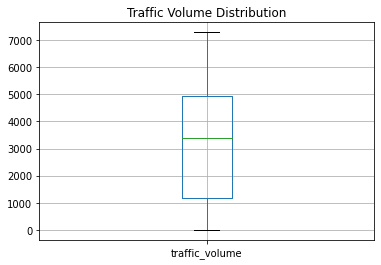

In [ ]:
ax = df_c[['traffic_volume']].boxplot()
ax.set_title('Traffic Volume Distribution') # in boxplot form
plt.show()

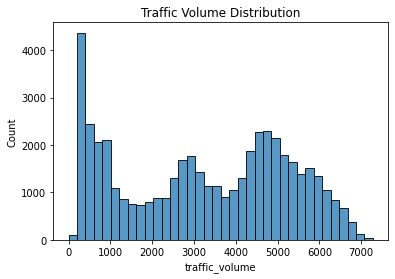

In [ ]:
ax = sns.histplot(data=df_c, x="traffic_volume")
ax.set_title('Traffic Volume Distribution') # in histogram form
plt.show()

### Cleaning up Temp and Rain

In [ ]:
df_c.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


Noticed that Min value for temp did not make sense. And also max value for rain did not make sense.

In [ ]:
# search for unreasonably low temps
# temps below 230K (or -46 F)
df_c[df_c['temp'] < 230]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
11898,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 03:00:00,361
11899,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 04:00:00,734
11900,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 05:00:00,2557
11901,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 06:00:00,5150
11946,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 03:00:00,291
11947,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 04:00:00,284
11948,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 05:00:00,434
11949,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 06:00:00,739
11950,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 07:00:00,962
11951,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 08:00:00,1670


I looked at values around these time/date ranges, and it was clear that these were mistakes, as the values hours apart from them were normal. To fix this problem, will impute the values from time just hours apart.

In [ ]:
dates = ['2014-01-31 03:00:00','2014-01-31 04:00:00','2014-01-31 05:00:00','2014-01-31 06:00:00']

In [ ]:
df_c['temp'][df_c['date_time'] == '2014-01-31 02:00:00'].values

array([255.93])

In [ ]:
# Using the temp value an hr before to impute for the outlier temp

for date in dates:
    df_c['temp'][df_c['date_time'] == date] = df_c['temp'][df_c['date_time'] == '2014-01-31 02:00:00'].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
dates_1 = ['2014-02-02 03:00:00','2014-02-02 04:00:00','2014-02-02 05:00:00','2014-02-02 06:00:00','2014-02-02 07:00:00','2014-02-02 08:00:00']

In [ ]:
df_c['temp'][df_c['date_time'] == '2014-02-02 02:00:00']

11945    255.37
Name: temp, dtype: float64

In [ ]:
# Using the temp value an hr before to impute for the outlier temp

for date in dates_1:
    df_c['temp'][df_c['date_time'] == date] = df_c['temp'][df_c['date_time'] == '2014-02-02 02:00:00'].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_c.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.258894,0.334264,0.000222,49.362231,3259.818355
std,12.713645,44.789133,0.008168,39.015750,1986.860670
min,243.390000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


Now temp is in a normal range. 

In [ ]:
df_c[df_c['rain_1h'] > 50]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
8247,None,289.10,55.63,0.0,68,Rain,very heavy rain,2013-08-07 02:00:00,315
24872,None,302.11,9831.30,0.0,75,Rain,very heavy rain,2016-07-11 17:00:00,5535


Look at rain values greater than 50 mm/hr.

In [ ]:
df_c[24866:24878]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
24866,None,296.45,0.00,0.0,90,Thunderstorm,proximity thunderstorm,2016-07-11 11:00:00,3998
24867,None,297.73,0.00,0.0,90,Rain,light rain,2016-07-11 12:00:00,4273
24868,None,299.15,0.00,0.0,75,Thunderstorm,proximity thunderstorm,2016-07-11 13:00:00,4475
24869,None,300.18,0.00,0.0,90,Clouds,overcast clouds,2016-07-11 14:00:00,4456
24870,None,300.81,0.00,0.0,75,Thunderstorm,proximity thunderstorm,2016-07-11 15:00:00,4858
24871,None,301.48,0.00,0.0,75,Thunderstorm,proximity thunderstorm,2016-07-11 16:00:00,5934
24872,None,302.11,9831.30,0.0,75,Rain,very heavy rain,2016-07-11 17:00:00,5535
24873,None,302.54,0.00,0.0,75,Thunderstorm,proximity thunderstorm,2016-07-11 18:00:00,3900
24874,None,302.39,0.00,0.0,75,Clouds,broken clouds,2016-07-11 19:00:00,2856
24875,None,302.45,0.00,0.0,75,Thunderstorm,thunderstorm,2016-07-11 20:00:00,2506


We see that this is clearly an outlier.

In [ ]:
# Could be possible that there was still heavy rainfall
# I set to value slightly higher than second highest 1 hr rainfall total

df_c['rain_1h'][df_c['date_time'] == '2016-07-11 17:00:00'] = 55.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_c.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.00000,48204.000000,48204.000000,48204.000000
mean,281.258894,0.13147,0.000222,49.362231,3259.818355
std,12.713645,1.03491,0.008168,39.015750,1986.860670
min,243.390000,0.00000,0.000000,0.000000,0.000000
25%,272.160000,0.00000,0.000000,1.000000,1193.000000
50%,282.450000,0.00000,0.000000,64.000000,3380.000000
75%,291.806000,0.00000,0.000000,90.000000,4933.000000
max,310.070000,55.80000,0.510000,100.000000,7280.000000


Now all the features, including rain_1h appear to be in a normal range.

In [ ]:
df = df_c

In [ ]:
# remove date_time feature
date_time = pd.to_datetime(df.pop('date_time'), format='%Y-%m-%d %H:%M:%S')

In [ ]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


### Time Series Visualizations

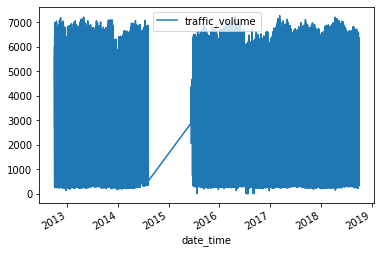

In [ ]:
plot_cols = ['traffic_volume']
plot_features = df[plot_cols]
plot_features.index = date_time
#_ = plot_features.plot(subplots=True)

#plot_features = df[plot_cols][:8760] # plotted 1 yr of data 
plot_features.index = date_time[:48204]
_ = plot_features.plot(subplots=True)

Here we see traffic volume over time, including the missing data between 2014 and 2015.

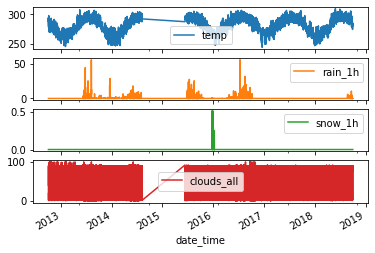

In [ ]:
plot_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']
plot_features = df[plot_cols]
plot_features.index = date_time
#_ = plot_features.plot(subplots=True)

#plot_features = df[plot_cols][:8760] # plotted 1 yr of data 
plot_features.index = date_time[:48204]
_ = plot_features.plot(subplots=True)

The numeric independent variables over time. As with traffic volume, of course you can see the gap in data for these variables as well between 2014 and 2015.

A few other observations about the patterns: snow distribution seems odd, as there is one big spike around 2016 and no comparable spikes for other years. Temp shows predictable periodicity. Rain seems somewhat periodic, but also more variable. And it seems like clouds are basically constant.

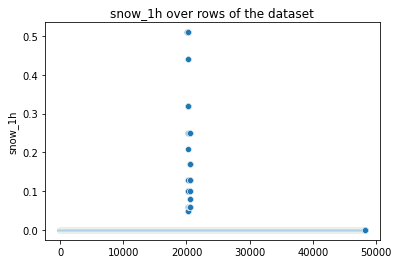

In [ ]:
ax = sns.scatterplot(data=df_c['snow_1h'])
ax.set_title('snow_1h over rows of the dataset')
plt.show()

In [ ]:
# tried removing snow variable and got
# comparable results
#df.drop(columns=['snow_1h'], inplace=True)

In [ ]:
df.snow_1h.value_counts()

0.00    48141
0.05       14
0.06       12
0.10        6
0.13        6
0.51        6
0.25        6
0.32        5
0.17        3
0.08        2
0.44        2
0.21        1
Name: snow_1h, dtype: int64

I also tried binarizing the snow_1h variable and looking at it over time - it is basically the same thing. It appears the snow data is very sparse, probably incomplete. But maybe the avalailable data for that short spurt in 2016 could be helpful.

In [ ]:
# create dummy variables for categorical variables
#holiday_dummies = pd.get_dummies(df.holiday)
#weather_main_dummies = pd.get_dummies(df.weather_main) redundant with weather description
#weather_description_dummies = pd.get_dummies(df.weather_description) #clouds_all, 1h rain, snow totals 
                                                                      #perhaps more reliable measure

In [ ]:
# drop standard categorical variables
df.drop(columns=['holiday', 'weather_main', 'weather_description'], inplace=True)

In [ ]:
#df = pd.concat([df, holiday_dummies, weather_main_dummies, weather_description_dummies], axis=1)
#df = pd.concat([df, holiday_dummies, weather_description_dummies], axis=1)
#df = pd.concat([df, holiday_dummies], axis=1) # holiday info not captured in rain, snow totals

I tried using all of the categorical variables as model inputs, but this gave worse results. Perhaps the values of weather_main and weather_description are better represented already by the numerical rain_1h, snow_1h, and clouds_all. Holiday, however, does not have representation other than the categorical 'holiday' feature. So I thought I would try to leave it in and see if the model could gain any insights from it. However, this did not improve results either, so I decided to take it out as well.

In [ ]:
df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,288.28,0.0,0.0,40,5545
1,289.36,0.0,0.0,75,4516
2,289.58,0.0,0.0,90,4767
3,290.13,0.0,0.0,90,5026
4,291.14,0.0,0.0,75,4918


In [ ]:
df.columns

Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume'], dtype='object')

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,48204.0,281.258894,12.713645,243.39,272.16,282.45,291.806,310.07
rain_1h,48204.0,0.131470,1.034910,0.00,0.00,0.00,0.000,55.80
snow_1h,48204.0,0.000222,0.008168,0.00,0.00,0.00,0.000,0.51
clouds_all,48204.0,49.362231,39.015750,0.00,1.00,64.00,90.000,100.00
traffic_volume,48204.0,3259.818355,1986.860670,0.00,1193.00,3380.00,4933.000,7280.00


### Splitting Data

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:33744] # approx 70% of df
val_df = df[33745:43203] # approx 20% of df 
test_df = df[43204:] # approx 10% of df

# used this split to try stateful = true, making train and val
# evenly divisible by a batch size of 28
#train_df = df[0:33946] # approx 70% of df 
#val_df = df[33945:43203] # approx 20% of df 
#test_df = df[43204:] # approx 10% of df

# tried making the val_df 10% instead of 20%
train_df = df[0:38202] # approx 80% of df
val_df = df[38203:43203] # approx 10% of df 
test_df = df[43204:] # approx 10% of df

num_features = df.shape[1]

In [ ]:
print(len(val_df))

5000


### Normalization

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

test_mean = test_df.mean()
test_std = test_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# test_df = test_df * train_std + train_mean
# to denormalize

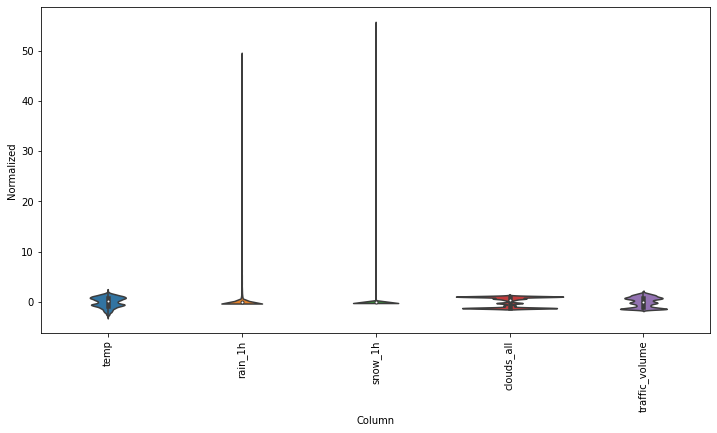

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Violin plot of the variables. Rain and snow 1h totals, as we expect given the variability of rainfall and snowfall, still have a large range, with a few values that are much larger than the rest. The other features have more normal distributuions.

## Code From TF Tutorial

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

### Experimenting with Batch Sizes

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False, #IW Changed shuffle to False
      # Note: I tried changing to true for training data and had comparable results
      # This did not make a significant difference with my model results,
      # so I left code out
      batch_size=5000,) # IW Experimented with batch sizes of 32, 64, 128, 5000, 8760

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Window Generation

In [ ]:
six_step_window = WindowGenerator(
    input_width=6, label_width=1, shift=2, #IW changed input_width to 6 and shift to 2
    label_columns=['traffic_volume'])
six_step_window

Total window size: 8
Input indices: [0 1 2 3 4 5]
Label indices: [7]
Label column name(s): ['traffic_volume']

In [ ]:
for example_inputs, example_labels in six_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (5000, 6, 4)
Labels shape (batch, time, features): (5000, 1, 1)


### Model Compile and Fit Function

In [ ]:
MAX_EPOCHS = 1000

def compile_and_fit(model, window, patience=3):

# IW Removed Early Stopping Callback
# I find sometimes this can be limiting
# Sometimes the model looks like it has hit a wall and is able to keep going
# I've found it helpful to see how the model overfits, using this information
# to think about implementation regularizations 

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val, shuffle=True, #IW added shuffle=True
                      callbacks=[LearningRateScheduler(lr_schedule)])
  return history

## Learning Rate Optimization

This was used with the later models.

In [ ]:
# added this to be passed in as a callback
# after trying multiple models and looking for another way 
# to improve performance
# changes learning rate based on # of epochs
# other combinations were used 

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 100:
        lrate = 0.0009
    if epoch > 200:
        lrate = 0.0008
    if epoch > 300:
        lrate = 0.0007
    if epoch > 400:
        lrate = 0.0006
    if epoch > 500:
        lrate = 0.0005
    if epoch > 600:
        lrate = 0.0004
    if epoch > 700:
        lrate = 0.0003
    return lrate

## Model Testing and Selection

### 16 Total Models Included

Some are not included - I tried quite a few more than this.

I left the models in the order that I tried them, to show the progression of different approaches. Most include comment code describing the changes made, as well as the performance change(s).

### Base Model

In [ ]:
# base model

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

# best results: val_loss: 0.12 , val_mae: 0.24

### Intermediate Models

In [ ]:
# model 1
# experimented with the batch sizes of 32, 64, 128
# batch size = 32 had best performance
# experimented with number of recurrent units: 32, 64, 128, 256
# units = 256 had best performance
# overfitting clearly a problem after a certain # of epochs
# experimented with combinations of the above
# best combination was bs = 32 , units = 256
# best results: val_loss: 0.09 , val_mae: .21

# It seemed like performance was somewhat subjective. What I mean by this is,
# a few times I got different results with the same configuration of batch size
# and units on separate runs, which I thought was odd

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=False), 
    tf.keras.layers.Dense(units=1)
])

In [ ]:
# model 2
# experimenting with stacked recurrent layers
# first added additional 128 unit layer, then another 64
# I noticed a dramatic increase in performance here on the validation data
# but the model did quickly start overfitting once it reached around 30+ epochs
# and even earlier the more layers I added on

# best results: val_loss: 0.082 , mae: 0.19

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
# model 3
# experimenting with dropout to help with overfitting
# model is much slower becuase cannot use cuDNN kernels after setting 
# recurrent dropout > 0, 46s/epoch, compared to <10s/epoch before
# however, improved performance on more epochs, less overfitting

# best results: val_loss: 0.078  mae: 0.185

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.LSTM(32, return_sequences=False, recurrent_dropout=0.2),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
# model 4
# experimenting with bidirectionality
# longer training time per /epoch
# get more warnings about not being able to use cuDNN kernels 
# because of bidirectionality as well as recurrent_dropout

# Best results: val_loss: .077  mae: 0.185

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences=True, recurrent_dropout=0.2)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=False, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
# model 5

# model 2 with added (normal) dropout
# best results: val_loss: 0.0765, val_mae = 0.18

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
# model 6

# model 2 with added (normal) dropout and recurrent dropout

# best results: val_loss: 0.072  val_mae: 0.18


lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, return_sequences=False, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

### BEST KAGGLE MODEL

In [ ]:
# model 7
# **BEST PERFORMING KAGGLE MODEL**
# 4-layer GRU
# faster convergence to low error metrics
# comparable performance to 4-layer LSTM, but scored higher on Kaggle 

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(256, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(128, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(64, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(32, return_sequences=False, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

### More Intermediate Models

In [ ]:
# model 9
# experimenting with Conv1D and GRU

lstm_model = Sequential()
lstm_model.add(Conv1D(64, kernel_size=3, activation = 'relu', input_shape=(6,5)))
model.add(Dropout(0.2))
lstm_model.add(MaxPooling1D(2))
lstm_model.add(GRU(256, return_sequences=True, recurrent_dropout=0.2))
lstm_model.add(Dense(100))
lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# model 10
# experimenting with Conv1D and LSTM

lstm_model = Sequential()
lstm_model.add(Conv1D(64, kernel_size=3, activation = 'relu', input_shape=(6,5)))
model.add(Dropout(0.2))
lstm_model.add(MaxPooling1D(2))
lstm_model.add(LSTM(256, return_sequences=True, recurrent_dropout=0.2))
lstm_model.add(Dense(100))
lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# model 11
# GRU layers from model 7
# but ran for more epochs and optimized learning rate
# lowered learning rate incrementally every 40 epochs using the 
# learning rate scheduler shown earlier 

# best results: hit a wall again around 0.075 , 0.18

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(256, return_sequences=True, recurrent_dropout=0.5),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(128, return_sequences=True, recurrent_dropout=0.5),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(64, return_sequences=True, recurrent_dropout=0.5),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(32, return_sequences=False, recurrent_dropout=0.5),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

### SECOND BEST MODEL

In [ ]:
# model 12
## **SECOND BEST PERFORMING KAGGLE MODEL**
# Note: this model performed 2nd best on Kaggle, but best on validation data
# Same structure as model 6
# Changed batch size to 8760 (the number of hours in a year)
# And then to 5000 (size of test data)
# Used Learning Rate Scheduler

# best results: val_loss: 0.0706  val_mae: 0.173
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, return_sequences=False, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

### Another Intermediate Model

In [ ]:
# model 13
# tried adding more units 
# also tried 512, 256, 128, 64
# also tried for LSTM
# did not see improvement 
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(1024, return_sequences=True, recurrent_dropout=0.3),
    tf.keras.layers.GRU(512, return_sequences=True, recurrent_dropout=0.3),
    tf.keras.layers.GRU(256, return_sequences=True, recurrent_dropout=0.3),
    tf.keras.layers.GRU(128, return_sequences=False, recurrent_dropout=0.3),
    tf.keras.layers.Dense(units=1)
])

### Best Intermediate Models

Note: These were the same structure as best models but with added Conv1D layer.

In [ ]:
# model 14
# combined Conv1D + Stacked LSTMs
# did not see improvment over original

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(256, kernel_size=3, activation = 'relu', input_shape=(6,5)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256, activation='relu', return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, return_sequences=False, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
# model 15
# combined Conv1D + Stacked GRUs
# did not see improvement over original 

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(256, kernel_size=3, activation = 'relu', input_shape=(6,5)),
    tf.keras.layers.GRU(256, activation='relu', return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(128, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(64, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(32, return_sequences=False, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

### Last Intermediate Model

In [ ]:
# model 16
# this was a model I tried based on a literature review
# did not outperform earlier best models

lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(256, return_sequences=True, recurrent_dropout=0.2),
        tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64, return_sequences=False, recurrent_dropout=0.2),
        tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

## Model Training

In [ ]:
print('Input shape:', six_step_window.example[0].shape)
print('Output shape:', lstm_model(six_step_window.example[0]).shape)

Input shape: (5000, 6, 5)
Output shape: (5000, 1)


### This trace is representative of the best models

Note: it is slightly worse than the best runs indicated above.

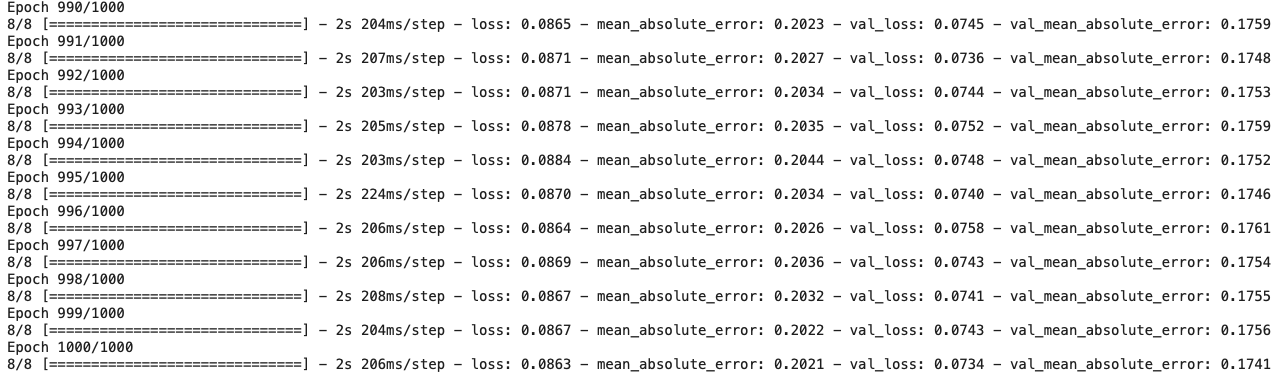

In [ ]:
# train and validate model up to specified # of epochs
# history = compile_and_fit(lstm_model, six_step_window)

NOTE: I ran this block as comments to remove the trace - as it was 1000 epochs long.
Since I now realize how these notebooks load when they're viewed after the fact (in many cases including all of the epochs shown unabridged), this is for efficiency in loading/viewing the notebook. I don't want there to be pages and pages of trace for you to have to scroll through. A screenshot of the results for the last 10 epochs is included above.

## Model Evaluation

#### Learning Curve - Best Model(s)

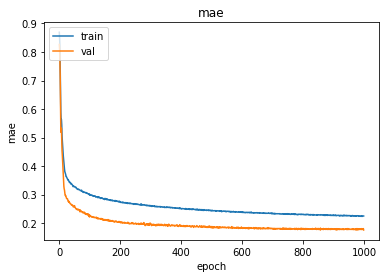

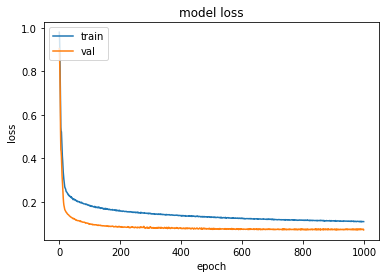

In [ ]:
# summarize history for mae
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The above curves show, in general, the error progression of the best models. 

As I moved to larger batch sizes later in the model iterations, this naturally increased the number of epochs.

All of my best models hit a wall around 0.0730 val_loss and 0.178 val_mae. I tried everything I could think of to get past this barrier.

#### Comparing Multiple Models

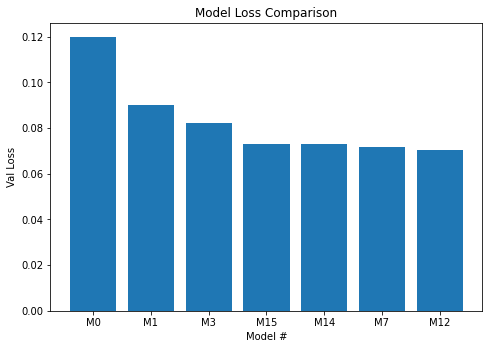

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Model Loss Comparison')
ax.set_xlabel('Model #')
ax.set_ylabel('Val Loss')
models = ['M0', 'M1', 'M3', 'M15', 'M14', 'M7', 'M12']
val_loss = [0.12, 0.09, 0.082, 0.0730, 0.0728, 0.0715, 0.0705]
ax.bar(models,val_loss)
plt.show()

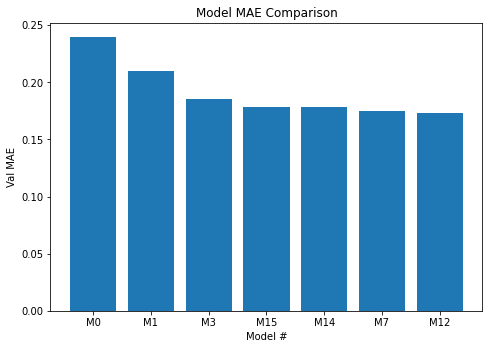

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Model MAE Comparison')
ax.set_xlabel('Model #')
ax.set_ylabel('Val MAE')
models = ['M0', 'M1', 'M3', 'M15', 'M14', 'M7', 'M12']
val_loss = [0.24, 0.21, 0.185, 0.178, 0.178, 0.175, 0.173]
ax.bar(models,val_loss)
plt.show()

The above figures show a picture of model progression from the base model (M0) to the best models (M15, M14, M7, and M12). We saw about a 40% decrease in loss from the base model to the best model. And about a 28% decrease in MAE from the base model to the best model. While this is a relatively large decrease, the base model held up surprisingly well to the more complex models with added hyperparameter tuning. 

## Prediction

In [ ]:
pred = lstm_model.predict(six_step_window.test)

In [ ]:
pred.shape

(4993, 1)

In [ ]:
pred_df = pd.DataFrame(pred)

In [ ]:
pred_df.head()

,0
0,-0.902394
1,-0.887471
2,-1.175825
3,-1.254389
4,-1.254629


## De-Normalization

In [ ]:
tv_std = train_std.traffic_volume
tv_mean = train_mean.traffic_volume

In [ ]:
dn_preds = pred_df * tv_std + tv_mean

In [ ]:
dn_preds.mean()

0    3336.486328
dtype: float32

## Exporting Predictions

In [ ]:
dn_preds.columns = ['prediction']
dn_preds.index.name = 'id'
dn_preds.index += 1
dn_preds.head()

,prediction
id,
1,1460.430420
2,1490.160889
3,915.708008
4,759.194580
5,758.715088


In [ ]:
dn_preds.to_csv('preds_f20.csv', sep = ',')
!cp preds_f20.csv "drive/My Drive/"

In total, I saved 21 different prediction files. 18 of these were submitted to Kaggle.